In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2

In [2]:
data_path = os.path.join('.', '../data_dl')

batch_size = 32
img_size = 224
random_state = 44

tf.keras.utils.set_random_seed(random_state)

In [3]:
def loadAndDivideIntoCategories(datasetPath, newImgSize):
  images, labels = list(), list()

  categories = os.listdir(datasetPath)
  for category in categories:
    categoryPath = datasetPath + "/" + category

    for imageName in os.listdir(categoryPath):
      if 'benign' in os.path.basename(os.path.normpath(categoryPath)):
          labels.append(0)
      elif 'malign' in os.path.basename(os.path.normpath(categoryPath)):
          labels.append(1)
      imagePath = categoryPath + "/" + imageName
      images.append(cv2.resize(cv2.imread(imagePath), (newImgSize, newImgSize), interpolation=cv2.INTER_CUBIC))       
  return images, labels

In [4]:
X, y = loadAndDivideIntoCategories(data_path, img_size)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

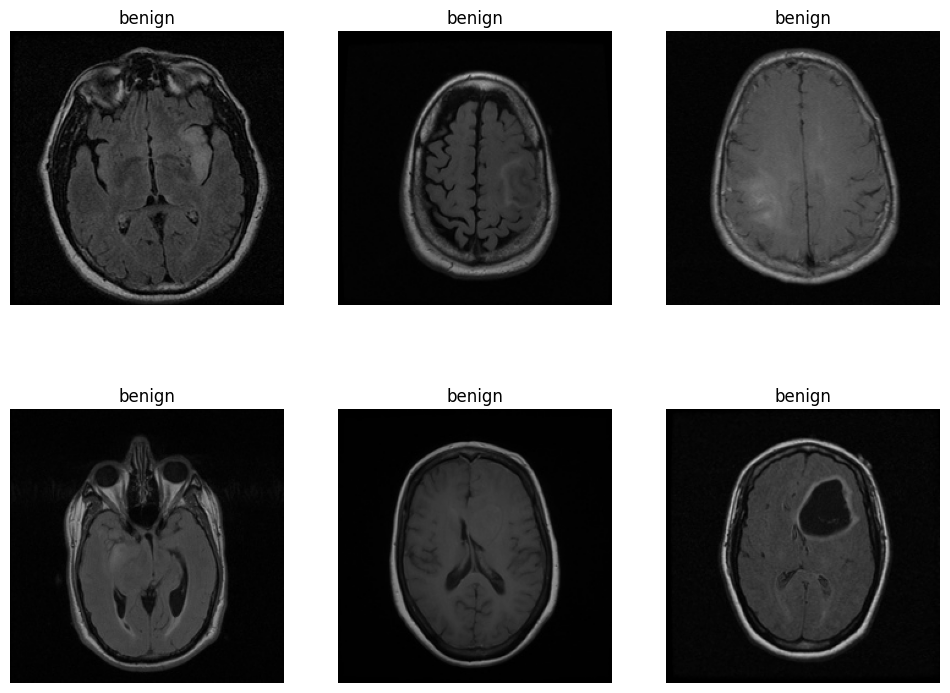

In [6]:
import random
labels = {0: 'benign', 1: 'malign'}

rows = 2
cols = 3

fig, axs = plt.subplots(rows, cols, figsize=(12,9))
 
for i in range(rows):
  for j in range(cols):
    idx = random.randint(0, len(X_train)-1)
    img, label = X_train[idx], y_train[idx]

    axs[i][j].axis('off')
    axs[i][j].imshow(img)
    axs[i][j].set_title(labels[np.argmax(label)])

# Augmentacja danych

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IDG = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

train_generator = IDG.flow(np.array(X_train), y_train, batch_size=batch_size)
val_generator = IDG.flow(np.array(X_val), y_val, batch_size=batch_size)

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),
                                               include_top=False,
                                               weights='imagenet')

In [9]:
print("Liczba warstw w modelu bazowym: ", len(base_model.layers))


Liczba warstw w modelu bazowym:  154


In [10]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [11]:
inputs = base_model.input
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

In [13]:
len(model.trainable_variables)

2

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [15]:
initial_epochs = 10

loss0, accuracy0, precision, recall, AUC = model.evaluate(train_generator)

print("startowa funkcja straty: {:.2f}".format(loss0))
print("Początkowa dokładność: {:.2f}".format(accuracy0))

c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 24s 633ms/step - loss: 0.7348 - binary_accuracy: 0.5187 - precision: 0.3236 - recall: 0.5130 - auc: 0.5226
startowa funkcja straty: 0.73
Początkowa dokładność: 0.52


In [16]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator)

Epoch 1/10
36/36 [==============================] - 30s 736ms/step - loss: 0.6729 - binary_accuracy: 0.6459 - precision: 0.3636 - recall: 0.1960 - auc: 0.5468 - val_loss: 0.5664 - val_binary_accuracy: 0.7071 - val_precision: 0.5714 - val_recall: 0.0952 - val_auc: 0.7276
Epoch 2/10
36/36 [==============================] - 26s 719ms/step - loss: 0.6255 - binary_accuracy: 0.6824 - precision: 0.4737 - recall: 0.2594 - auc: 0.6233 - val_loss: 0.5671 - val_binary_accuracy: 0.7071 - val_precision: 0.5122 - val_recall: 0.5000 - val_auc: 0.7190
Epoch 3/10
36/36 [==============================] - 27s 735ms/step - loss: 0.6023 - binary_accuracy: 0.6922 - precision: 0.5022 - recall: 0.3285 - auc: 0.6555 - val_loss: 0.5798 - val_binary_accuracy: 0.7286 - val_precision: 0.7500 - val_recall: 0.1429 - val_auc: 0.6879
Epoch 4/10
36/36 [==============================] - 27s 742ms/step - loss: 0.6138 - binary_accuracy: 0.6931 - precision: 0.5053 - recall: 0.2738 - auc: 0.6368 - val_loss: 0.5473 - val_bin

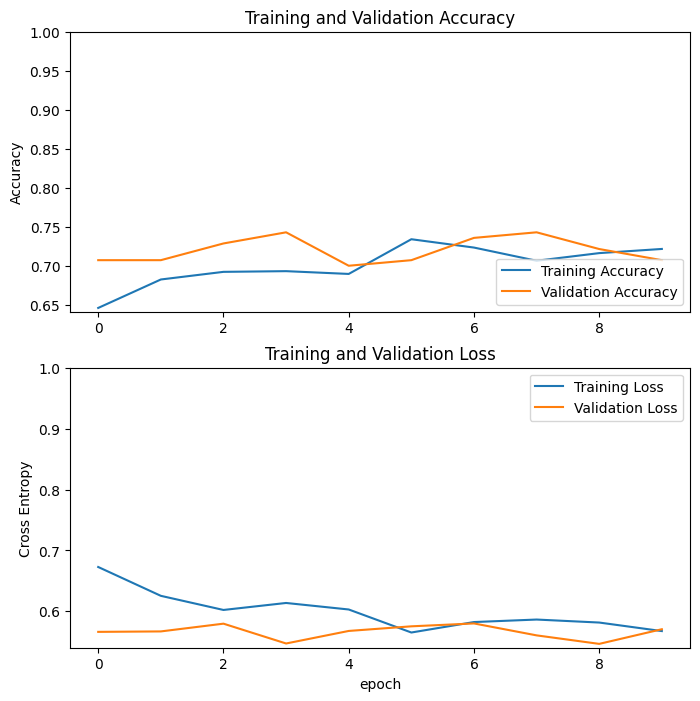

In [17]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Dostrajanie 

In [18]:
base_model.trainable = True

In [19]:
print("Liczba warstw w modelu bazowym: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Liczba warstw w modelu bazowym:  154


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [22]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator)

Epoch 10/20
36/36 [==============================] - 49s 1s/step - loss: 0.6117 - binary_accuracy: 0.6993 - precision_1: 0.5354 - recall_1: 0.1960 - auc_1: 0.6388 - val_loss: 0.5302 - val_binary_accuracy: 0.7714 - val_precision_1: 0.7778 - val_recall_1: 0.3333 - val_auc_1: 0.7338
Epoch 11/20
36/36 [==============================] - 43s 1s/step - loss: 0.6030 - binary_accuracy: 0.7011 - precision_1: 0.5385 - recall_1: 0.2219 - auc_1: 0.6497 - val_loss: 0.5492 - val_binary_accuracy: 0.7214 - val_precision_1: 0.6154 - val_recall_1: 0.1905 - val_auc_1: 0.7300
Epoch 12/20
36/36 [==============================] - 43s 1s/step - loss: 0.5860 - binary_accuracy: 0.7198 - precision_1: 0.6013 - recall_1: 0.2738 - auc_1: 0.6721 - val_loss: 0.5347 - val_binary_accuracy: 0.7500 - val_precision_1: 0.6296 - val_recall_1: 0.4048 - val_auc_1: 0.7346
Epoch 13/20
36/36 [==============================] - 43s 1s/step - loss: 0.5847 - binary_accuracy: 0.7126 - precision_1: 0.5600 - recall_1: 0.3228 - auc_1: 0

In [23]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

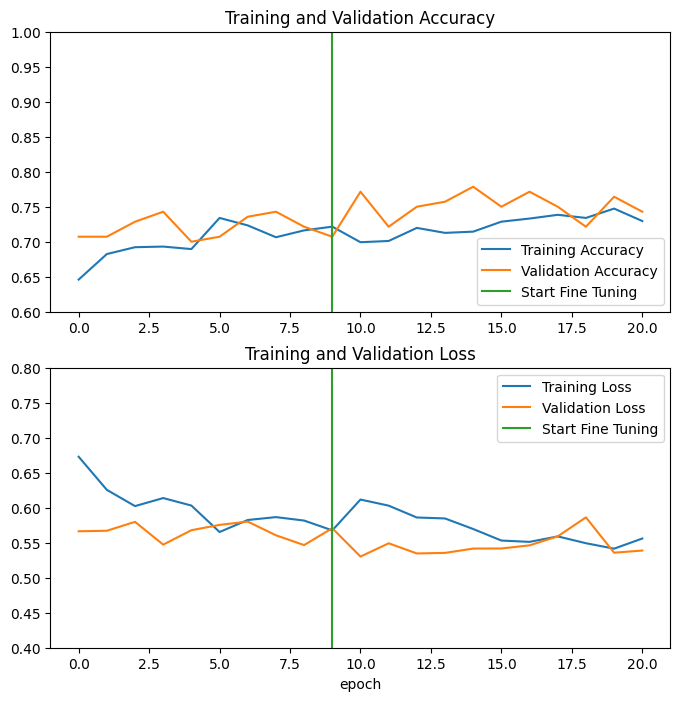

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.4, 0.8])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Validation Dataset

In [59]:
def predict_proba_for_all(X, model):
    y_pred_proba = []
    for x in X:
        y_pred_proba.append(model.predict(np.array([x]), verbose=0).squeeze())

    return y_pred_proba

y_pred_proba = predict_proba_for_all(X_val, model)

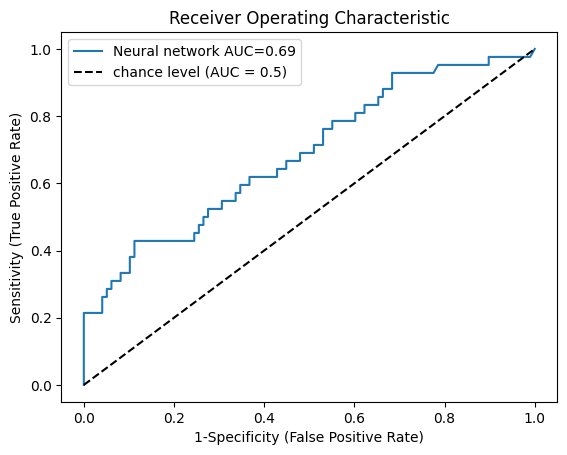

In [60]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label=f"Neural network AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [61]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

best_f1 = 0
best_th = None
thresholds_lst = list(thresholds)
thresholds_lst.append(0.5)

y_pred_proba = np.array(y_pred_proba)
for threshold in thresholds_lst:
    y_pred = y_pred_proba > threshold
    f1 = f1_score(y_val, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_th = threshold

In [62]:
import pandas as pd
name = "MobileNetV2"
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

y_pred = y_pred_proba > 0.5
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_val, y_pred))
results['F1 score'].append(f1_score(y_val, y_pred))
results['Precision'].append(precision_score(y_val, y_pred))
results['Recall'].append(recall_score(y_val, y_pred))
results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results before threshold adjustment on TEST data")
results_df.head()

Results before threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,MobileNetV2,0.735714,0.212766,1.0,0.119048,0.195032


In [63]:

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

y_pred = y_pred_proba > best_th
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_val, y_pred))
results['F1 score'].append(f1_score(y_val, y_pred))
results['Precision'].append(precision_score(y_val, y_pred))
results['Recall'].append(recall_score(y_val, y_pred))
results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head()

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,MobileNetV2,0.492857,0.517007,0.361905,0.904762,0.195032


In [64]:
name = "EfficientNetV2M"
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

y_pred = y_pred_proba > best_th
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_val, y_pred))
results['F1 score'].append(f1_score(y_val, y_pred))
results['Precision'].append(precision_score(y_val, y_pred))
results['Recall'].append(recall_score(y_val, y_pred))
results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head()

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,EfficientNetV2M,0.492857,0.517007,0.361905,0.904762,0.195032


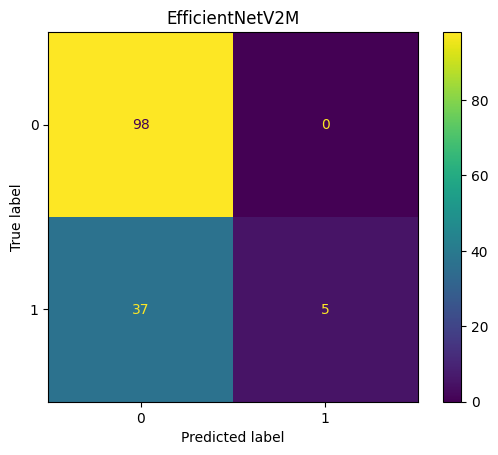

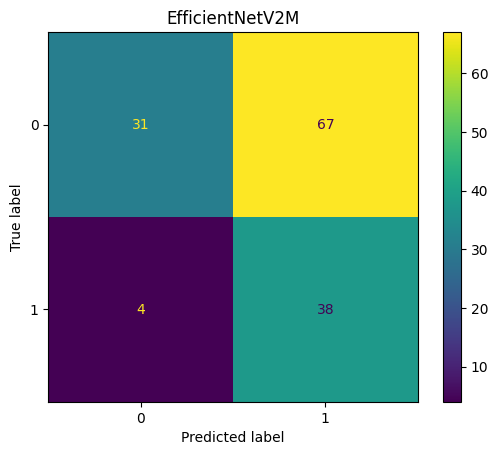

In [65]:
y_pred = y_pred_proba > 0.5
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"{name}")
plt.show()


y_pred = y_pred_proba > best_th
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"{name}")
plt.show()

#### Test Dataset

In [66]:
def predict_proba_for_all(X, model):
    y_pred_proba = []
    for x in X:
        y_pred_proba.append(model.predict(np.array([x]), verbose=0).squeeze())

    return y_pred_proba
name = "MoblieNetV2"
y_pred_proba = predict_proba_for_all(X_test, model)

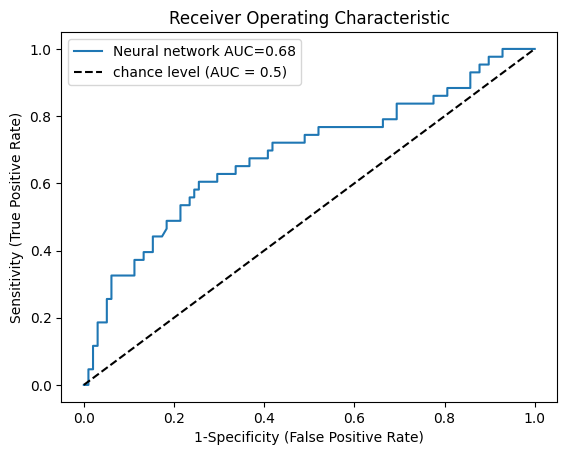

In [67]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label=f"Neural network AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

best_f1 = 0
best_th = None
thresholds_lst = list(thresholds)
thresholds_lst.append(0.5)

y_pred_proba = np.array(y_pred_proba)
for threshold in thresholds_lst:
    y_pred = y_pred_proba > threshold
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_th = threshold

In [69]:
import pandas as pd

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

y_pred = y_pred_proba > 0.5
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_test, y_pred))
results['F1 score'].append(f1_score(y_test, y_pred))
results['Precision'].append(precision_score(y_test, y_pred))
results['Recall'].append(recall_score(y_test, y_pred))
results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results before threshold adjustment on TEST data")
results_df.head()

Results before threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,MoblieNetV2,0.695035,0.044444,0.5,0.023256,0.283503


In [70]:
name = "MoblieNetV2"
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

y_pred = y_pred_proba > best_th
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_test, y_pred))
results['F1 score'].append(f1_score(y_test, y_pred))
results['Precision'].append(precision_score(y_test, y_pred))
results['Recall'].append(recall_score(y_test, y_pred))
results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head()

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,MoblieNetV2,0.702128,0.543478,0.510204,0.581395,0.283503


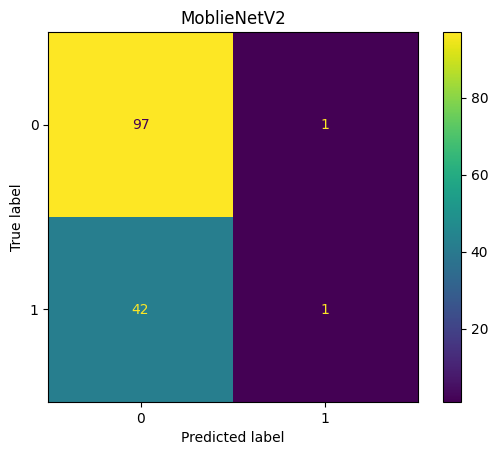

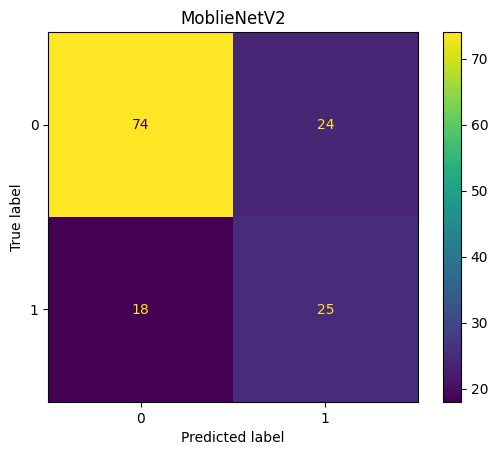

In [71]:
y_pred = y_pred_proba > 0.5
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"{name}")
plt.show()


y_pred = y_pred_proba > best_th
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"{name}")
plt.show()